# Q-learning with function approximation - egocentric environment

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/NiloufarRazmi/RL_Olfaction/HEAD?labpath=FuncApprox%2FFuncApprox_ego.ipynb)

## The task

<img src='./img/task.png' width="400">

## Initialization

In [1]:
# Import packages
# from pprint import pprint

import numpy as np
from tqdm import tqdm
import pandas as pd

In [2]:
# Load custom functions
from utils import Params
from environment_ego import (
    WrappedEnvironment,
    Actions,
    CONTEXTS_LABELS,
    LightCues,
    OdorID,
)
from agent import QLearningFuncApprox, EpsilonGreedy
import plotting
import plotting_ego

In [3]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Choose the task parameters

In [4]:
# Choose the parameters for the task
params = Params(epsilon=0.1, n_runs=3, numEpisodes=2000, alpha=0.025)
params

Params(epsilon=0.1, gamma=0.8, alpha=0.025, jointRep=True, n_runs=3, numEpisodes=2000)

## Load the environment and the agent algorithms

In [5]:
# Load the environment
env = WrappedEnvironment(params)

In [6]:
# Manually engineered features, optional
# if `None`, a diagonal matrix of features will be created automatically
features = np.matlib.repmat(
    np.eye(
        len(env.tiles_locations) * len(env.head_angle_space),
        len(env.tiles_locations) * len(env.head_angle_space),
    ),
    len(LightCues) * len(OdorID),
    len(LightCues) * len(OdorID),
)
features = None

In [7]:
# Load the agent algorithms
learner = QLearningFuncApprox(
    learning_rate=params.alpha,
    gamma=params.gamma,
    state_size=env.numStates,
    action_size=env.numActions,
    features_matrix=features,
)
explorer = EpsilonGreedy(epsilon=params.epsilon)

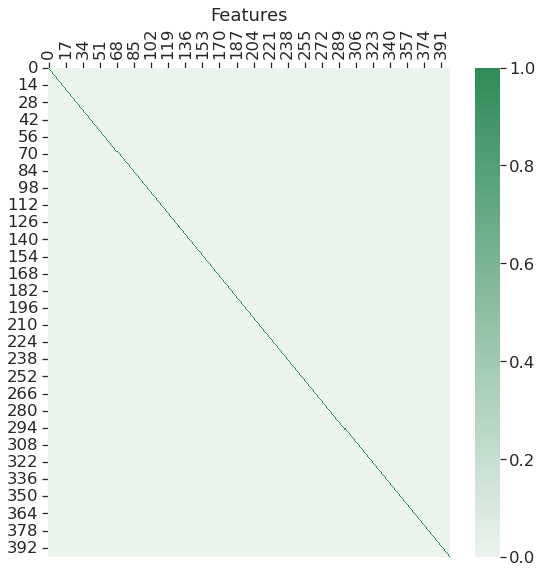

In [8]:
plotting.plot_heatmap(matrix=learner.features, title="Features")

## States and actions meaning

In [9]:
env.get_states_structure()

OrderedDict([(<LightCues.North: 4>,
              OrderedDict([(0,
                            array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
                                   17, 18, 19, 20, 21, 22, 23, 24])),
                           (90,
                            array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
                                   42, 43, 44, 45, 46, 47, 48, 49])),
                           (180,
                            array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
                                   67, 68, 69, 70, 71, 72, 73, 74])),
                           (270,
                            array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
                                   92, 93, 94, 95, 96, 97, 98, 99]))])),
             (<LightCues.South: 20>,
              OrderedDict([(0,
                            array([100, 101, 102, 103, 104, 105, 106, 10

### Correspondance between flat states and (internal) composite states

In [10]:
state = 63
env.convert_flat_state_to_composite(state)

{'location': 13, 'direction': 180, 'cue': <LightCues.North: 4>}

In [11]:
state = {"location": 13, "direction": 90, "cue": LightCues.North}
env.convert_composite_to_flat_state(state)

38

### Action meaning

In [12]:
action = 0
Actions(action)

<Actions.FORWARD: 0>

## Main loop

In [13]:
rewards = np.zeros((params.numEpisodes, params.n_runs))
steps = np.zeros((params.numEpisodes, params.n_runs))
episodes = np.arange(params.numEpisodes)
qtables = np.zeros((params.n_runs, *learner.Q_hat_table.shape))
all_states = []
all_actions = []

for run in range(params.n_runs):  # Run several times to account for stochasticity
    learner.reset_Q_hat_table()  # Reset the Q-table between runs

    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{params.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        step_count = 0
        done = False
        total_rewards = 0

        while not done:
            learner.Q_hat_table = learner.Q_hat(learner.weights, learner.features)

            action = explorer.choose_action(
                action_space=env.action_space,
                state=state,
                qtable=learner.Q_hat_table,
            )

            # Record states and actions
            all_states.append(state)
            all_actions.append(Actions(action).name)

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done = env.step(action, state)

            learner.weights[:, action] = learner.update_weights(
                state, action, reward, new_state
            )

            total_rewards += reward
            step_count += 1

            # Our new state is state
            state = new_state

        # explorer.epsilon = explorer.update_epsilon(episode)

        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count
    qtables[run, :, :] = learner.Q_hat_table

## Postprocessing

In [14]:
res = pd.DataFrame(
    data={
        "Episodes": np.tile(episodes, reps=params.n_runs),
        "Rewards": rewards.flatten(),
        "Steps": steps.flatten(),
    }
)
res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
# st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
qtable = qtables.mean(axis=0)  # Average the Q-table between runs

In [15]:
res

,Episodes,Rewards,Steps,cum_rewards
0,0,10.0,29.0,10.0
1,1,10.0,12.0,10.0
2,2,10.0,11.0,20.0
3,3,0.0,471.0,20.0
4,4,10.0,14.0,30.0
...,...,...,...,...
5995,1995,10.0,9.0,17960.0
5996,1996,10.0,5.0,17970.0
5997,1997,10.0,17.0,17980.0
5998,1998,10.0,18.0,17990.0


In [16]:
# plotting.qtable_directions_map(qtable, env.rows, env.cols)

## Visualization

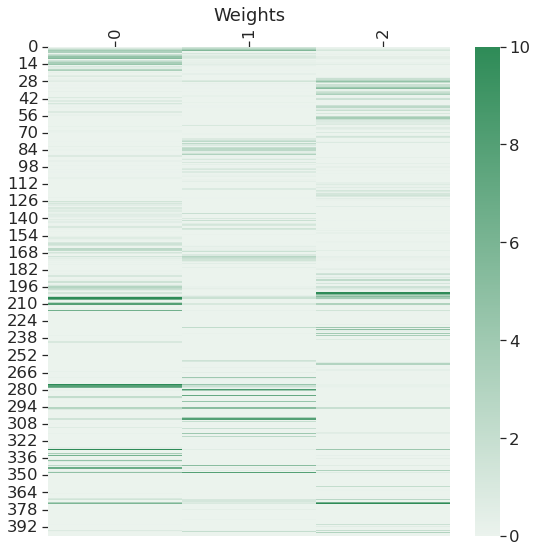

In [17]:
plotting.plot_heatmap(matrix=learner.weights, title="Weights")

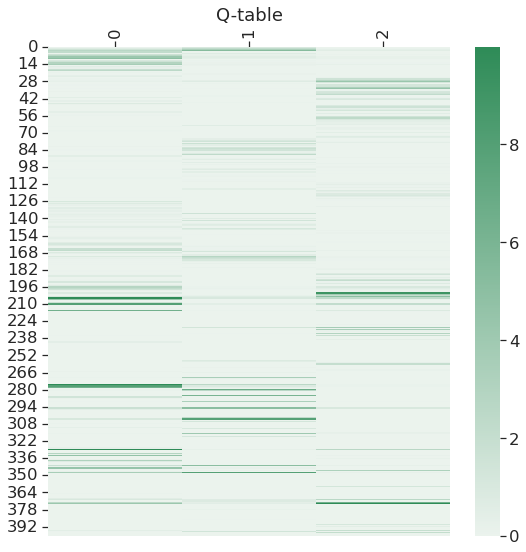

In [18]:
plotting.plot_heatmap(matrix=qtable, title="Q-table")

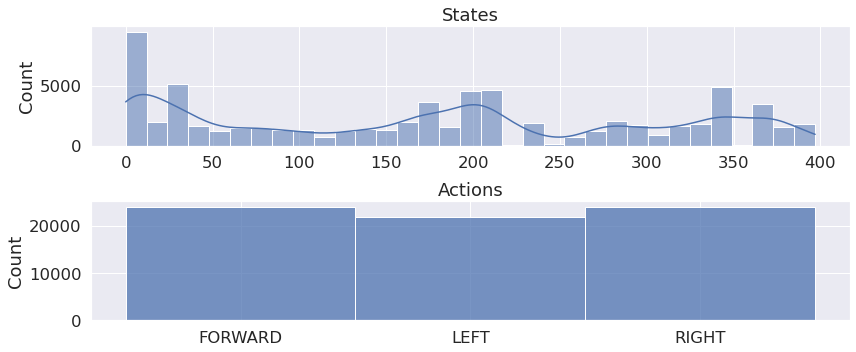

In [19]:
plotting.plot_states_actions_distribution(all_states, all_actions)

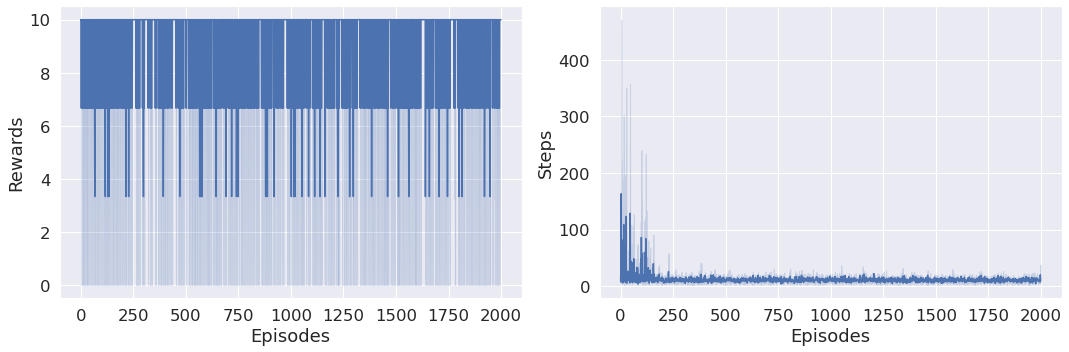

In [20]:
plotting.plot_steps_and_rewards(res)

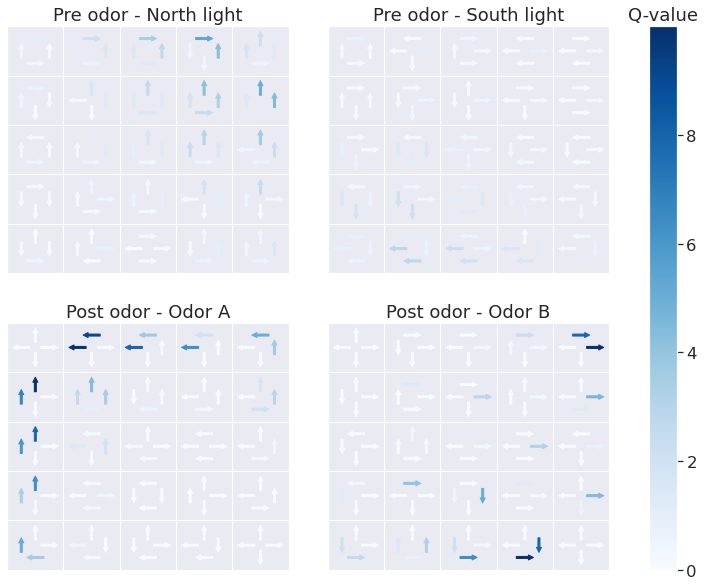

In [74]:
plotting_ego.plot_ego_q_values_maps(
    qtable, env.rows, env.cols, CONTEXTS_LABELS, env.get_states_structure()
)

In [53]:
q_val_best = plotting_ego.qtable_directions_map_ego(
    qtable, env.rows, env.cols, env.get_states_structure()
)
# pprint(q_val_best)

In [63]:
env.get_states_structure()[OdorID.A]

OrderedDict([(0,
              array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
                     213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224])),
             (90,
              array([225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
                     238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249])),
             (180,
              array([250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262,
                     263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274])),
             (270,
              array([275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287,
                     288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299]))])

In [64]:
env.get_states_structure()[OdorID.A][0].reshape(5, 5)

array([[200, 201, 202, 203, 204],
       [205, 206, 207, 208, 209],
       [210, 211, 212, 213, 214],
       [215, 216, 217, 218, 219],
       [220, 221, 222, 223, 224]])

In [62]:
np.argmax(qtable, axis=0)

array([329, 348, 373])

In [37]:
qtable[205, :], qtable[318, :], qtable[201, :]

(array([9.99995625, 1.00869583, 2.27908241]),
 array([2.61687500e-04, 1.17832961e+00, 2.49611140e-02]),
 array([8.45085960e-01, 4.20433011e-03, 9.14244015e+00]))

In [38]:
Actions(0), Actions(1), Actions(2)

(<Actions.FORWARD: 0>, <Actions.RIGHT: 1>, <Actions.LEFT: 2>)

In [65]:
q_val_best[OdorID.A][0]["q_max"][5], q_val_best[OdorID.A][0]["best_action"][5]

(9.999956254573647, functools.partial(<function arrow_up at 0x7feb805d72e0>))

In [66]:
q_val_best[OdorID.A][0]["q_max"][1], q_val_best[OdorID.A][0]["best_action"][1]

(9.1424401544612, functools.partial(<function arrow_left at 0x7feb805d7600>))

In [67]:
plotting_ego.map_action_to_direction(Actions(0), 0)

functools.partial(<function arrow_up at 0x7feb805d72e0>)

In [68]:
plotting_ego.map_action_to_direction(Actions(2), 0)

functools.partial(<function arrow_left at 0x7feb805d7600>)